# Pre-Pruning and Post-Pruning in Decision Trees  

---

# 1. Why Prune?

Decision trees are powerful but highly prone to **overfitting** because they keep splitting until every leaf is pure.  
**Pruning** controls this overfitting by reducing tree complexity.

Two major methods:

- **Pre-Pruning (Early Stopping):**  
  Stop the tree from growing fully by imposing limits such as maximum depth, minimum samples, etc.

- **Post-Pruning:**  
  First grow a full (or very large) tree, then prune unnecessary branches.

---

# 2. Objective Behind Pruning

Pruning addresses the **bias–variance tradeoff**:

- Pre-pruning increases bias but reduces variance.
- Post-pruning keeps bias low early, then reduces variance later.

### Cost-Complexity Objective (used in CCP Pruning)

$$
R_\alpha(T) = R(T) + \alpha |T|
$$

Where:

- $R(T)$ = empirical risk (impurity of leaves)  
- $|T|$ = number of terminal nodes  
- $\alpha$ = complexity penalty  

More $\alpha$ → smaller trees.

---

# 3. Pre-Pruning (Early Stopping)

These hyperparameters prevent overgrowth:

- `max_depth`
- `min_samples_split`
- `min_samples_leaf`
- `min_weight_fraction_leaf`
- `max_leaf_nodes`
- `max_features`
- `min_impurity_decrease`

### When to use:

- Need speed or memory efficiency  
- Want small interpretable trees  
- Dataset is small  


### example 1:  Simple Pre - Pruning 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("Social_Network_Ads.csv")

In [6]:
df.head(2)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0


In [7]:
df.drop(columns= ["User ID", "Gender"], inplace = True)

In [8]:
df.head(2)

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0


In [9]:
x = df.iloc[:,:-1]

In [10]:
y = df['Purchased']

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
ss = StandardScaler()

In [13]:
ss.fit(x)

StandardScaler()

In [14]:
x = pd.DataFrame(data = ss.transform(x), columns = x.columns)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [17]:
from sklearn.tree import DecisionTreeClassifier

### **Using `max_depth` parameter to limit the depth of the tree : basically pre-prunning**

In [18]:
dtc = DecisionTreeClassifier(max_depth = 5)

In [19]:
dtc.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [20]:
dtc.score(x_test, y_test)*100

90.0

In [21]:
dtc.score(x_train, y_train)*100

93.4375

In [22]:
from mlxtend.plotting import plot_decision_regions

/home/akash/myEnv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


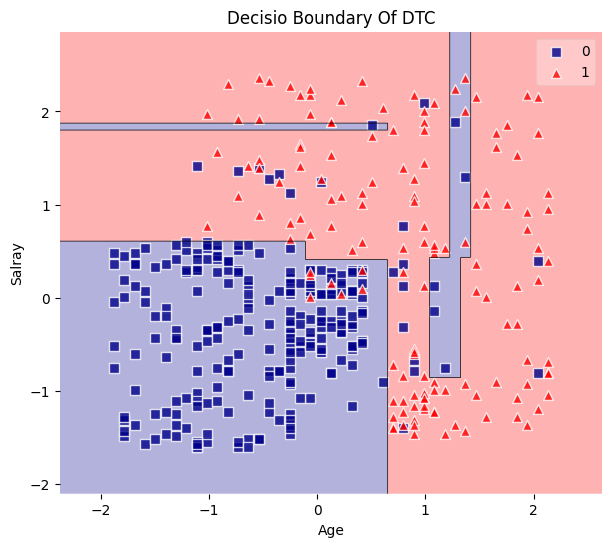

In [ ]:
plt.figure(figsize = (7,6))
plt.title("Decision Boundary Of DTC")

plot_decision_regions(
    
    x.to_numpy(),
    y.to_numpy(),
    clf = dtc,
    zoom_factor = 2,
    colors = "darkblue,red",
    scatter_kwargs = dict( s = 50, alpha = 0.8,linewidth = 1 ,edgecolor = "white"),
    contourf_kwargs = dict(alpha = 0.3,) #contourf_kwargs parameter is used for setting parameter for fiiled contour function 
    # basically to control/fill the decision regions
)

plt.xlabel("Age")
plt.ylabel("Salray")

plt.show()

In [24]:
from sklearn.tree import plot_tree

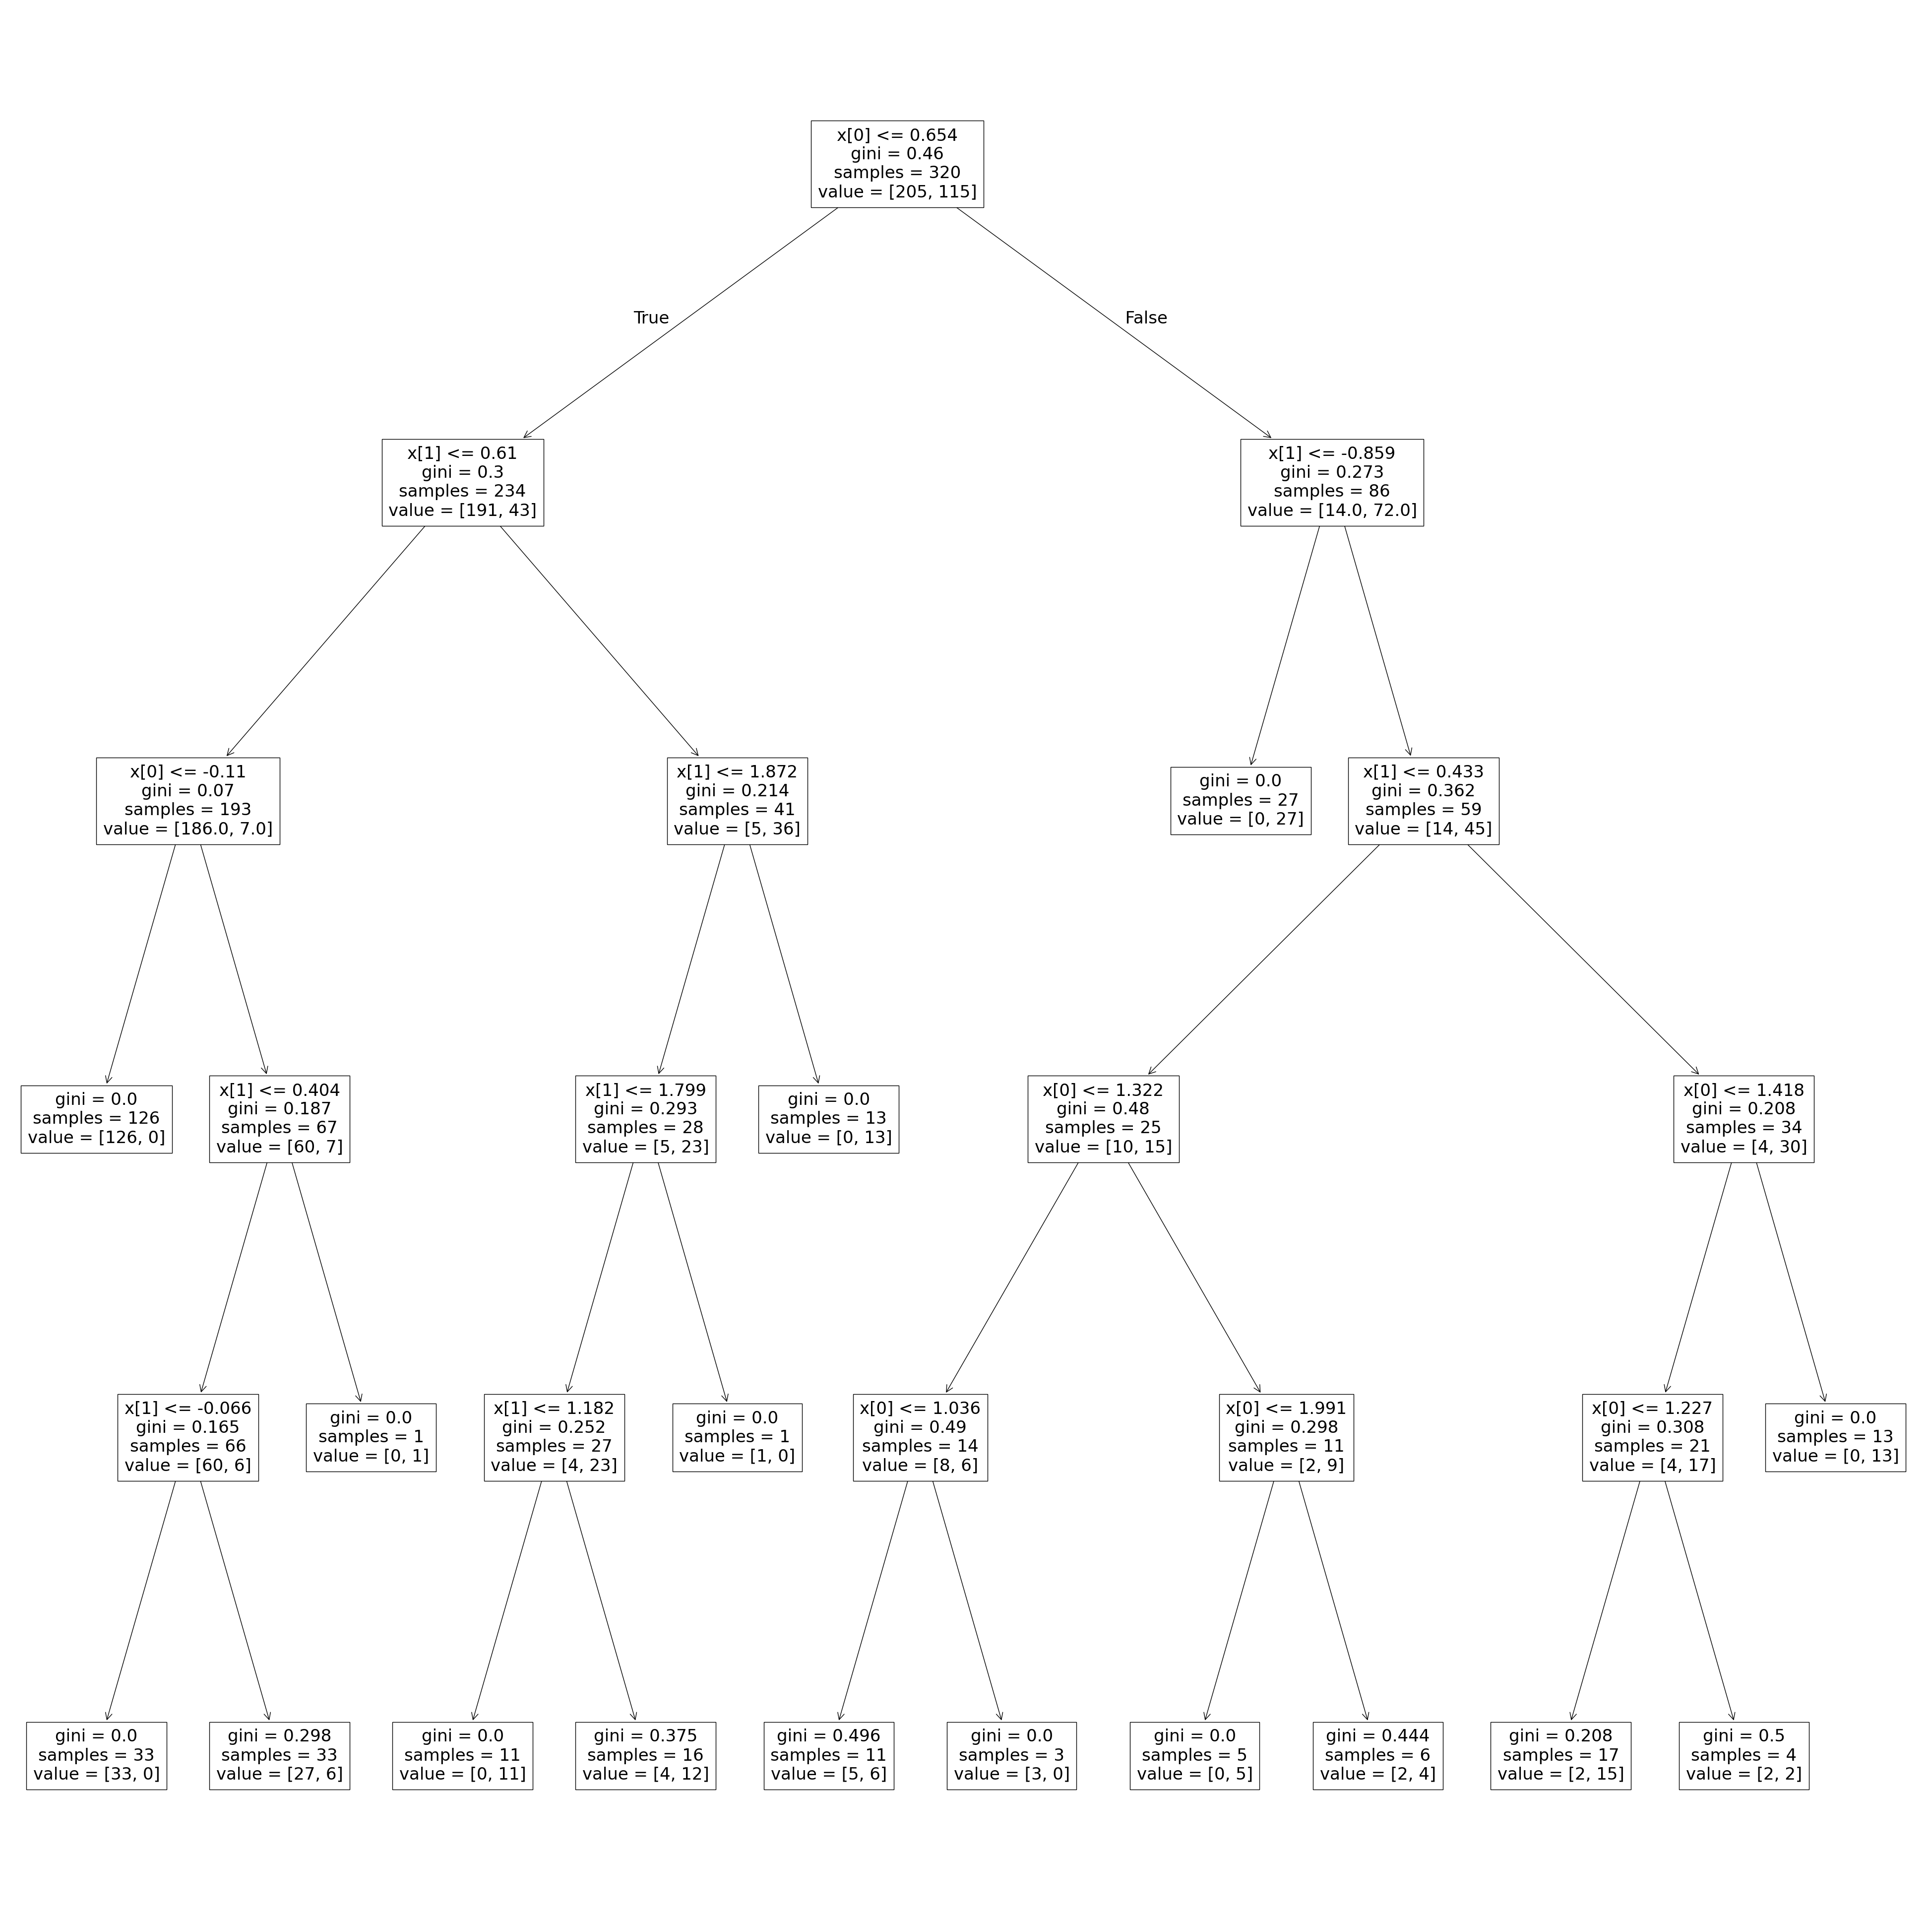

In [25]:
plt.figure(figsize = (50,50))
plot_tree(dtc)
plt.show()

# 4. Post-Pruning: Methods, Details, and Code

Post-pruning refers to pruning a decision tree **after** it has been fully grown.  
This reduces overfitting and improves generalization by removing unnecessary branches.

---

## 4.1 Cost-Complexity Pruning (a.k.a. CCP / Weakest-Link Pruning)

Scikit-learn provides two key tools for CCP pruning:

- `cost_complexity_pruning_path`
- `ccp_alpha` in `DecisionTreeClassifier` / `DecisionTreeRegressor`

---

### **Algorithm Sketch**

1. **Grow the full tree**  
   Let the fully grown tree be $T_0$

2. **Generate a sequence of complexity parameters**  
   For a sequence of values $\alpha$
   compute the corresponding pruned trees  $T_\alpha$
   such that each tree minimizes the cost-complexity objective:
   $ R_\alpha(T) = R(T) + \alpha |T| $

3. **Select the best alpha**  
   Evaluate each pruned tree using validation or cross-validation  
   and select the value of  $\alpha$ that gives the best accuracy/generalization.


# 🌳 Post-Pruning: Cost-Complexity Pruning (CCP)

**Post-pruning** is the process of cutting down a fully grown decision tree to remove noise, reduce overfitting, and improve generalization.  
The most common method used in **Scikit-Learn** is **Cost-Complexity Pruning (CCP)**, also called **Weakest Link Pruning**.

---

## 1. 🧠 The Intuitive Concept: "Running a Business"

Imagine the Decision Tree as a **Company**.

| Tree Component | Business Analogy |
| --- | --- |
| **Leaves (Terminal Nodes)** | **Employees** 👷‍♂️ |
| **Error Rate (Impurity)** | **Mistakes / Unfinished Work** 📉 |
| **Alpha ($\alpha$)** | **Salary per Employee** 💰 |

### 🎯 The Goal

You want to minimize the total cost of running the business:

$$
\text{Total Cost} = (\text{Mistakes Made}) + (\text{Salary} \times \text{Count of Employees})
$$

---

### ⚖️ The Trade-off

- **If** $\alpha \approx 0$:  
  Labor is cheap → You hire many employees → Tree becomes large → **Overfitting**

- **If** $\alpha$ is large:  
  Labor is expensive → You fire most employees → Tree becomes tiny → **Underfitting**

---

## 2. ⚙️ Mathematical Objective Function

We treat pruning as an optimization problem.  
We search for a subtree $T$ that minimizes the **Cost-Complexity Measure**:

$$
R_{\alpha}(T) = R(T) + \alpha|T|
$$

Where:

- $R(T)$ = **Empirical Risk / Total impurity** of the tree  
  (Sum of weighted leaf impurities)
- $|T|$ = **Number of terminal nodes** (leaves)
- $\alpha$ = **Complexity penalty parameter**

---

## 3. 📉 Effective Alpha — “Cost at Which a Branch Dies”

For any internal node $t$, we compare:

1. **Keep the entire subtree $T_t$**
2. **Prune the branch**, replacing it with a single leaf

We keep the branch if its cost is lower:

$$
R(T_t) + \alpha|T_t| < R(t) + \alpha \cdot 1
$$

---

### 🧮 Deriving the Threshold $\alpha_{\text{eff}}$

Start from the equality point:

$$
R(T_t) + \alpha|T_t| = R(t) + \alpha
$$

Move terms:

$$
R(T_t) - R(t) = \alpha - \alpha|T_t|
$$

Factor $\alpha$ on RHS:

$$
R(T_t) - R(t) = \alpha(1 - |T_t|)
$$

Multiply both sides by $-1$:

$$
R(t) - R(T_t) = \alpha(|T_t| - 1)
$$

Solve for $\alpha$:

$$
\alpha_{\text{eff}}(t) = \frac{R(t) - R(T_t)}{|T_t| - 1}
$$

---

### 📌 Interpretation

$$
\alpha_{\text{eff}} = 
\frac{\text{Purity Gain (benefit)}}{\text{Added Leaves (cost of complexity)}}
$$

- It tells **how much impurity improvement you get per new leaf**.
- If your **global $\alpha$ > $\alpha_{\text{eff}}$**,  
  → the branch "cannot pay its rent" → **pruned**

---

## 4. ✂️ Algorithm: Weakest Link Pruning

1. Grow the **full tree** $T_0$
2. Compute $\alpha_{\text{eff}}$ for every internal node
3. Find the smallest $\alpha_{\text{eff}}$ (weakest link)
4. **Prune** that subtree
5. Repeat until only the root remains

This yields a monotonic list:

$$
[\alpha_0,\ \alpha_1,\ \alpha_2,\ ...]
$$

---

## 5. 🛠️ Practical Workflow (Scikit-Learn)

We don’t guess $\alpha$.  
We **extract the pruning path** and evaluate.

- **Generate pruning path**

```python
path = clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas
```

- **Train Models:** Train a new DecisionTreeClassifier for every $\\alpha$ in the list.
  
- **Cross-Validate:** Test each tree on validation data.
  
- **Select Best:** Plot **Accuracy vs. Alpha**. Pick the $\\alpha$ where Test Accuracy is highest (the "Sweet Spot" before it drops off due to underfitting).

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
clf = DecisionTreeClassifier(random_state = 0)

In [28]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

In [29]:
# Getting effective alphas and corresponding total impurities
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [32]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf_temp = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_temp.fit(x_train, y_train)
    clfs.append(clf_temp)

In [34]:
# evaluation validation set
train_scores  = [c.score(x_train, y_train) for c in clfs]
test_scores = [c.score(x_test, y_test) for c in clfs]

In [37]:
#finding best alpha
best_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_index]
best_clf = clfs[best_index]

print(f"Best ccp_alpha: {best_alpha}")
print(f"Validation Accuracy: {test_scores[best_index]}")
print(f"Training Accuracy: {train_scores[np.argmax(train_scores)]}")

Best ccp_alpha: 0.0036764705882352936
Validation Accuracy: 0.925
Training Accuracy: 0.996875


####  **Explanation:**

- `cost_complexity_pruning_path` returns a sorted array of candidate `ccp_alpha` values (from 0 up).

- For each alpha we retrain/prune and evaluate on a validation set (or with CV).

- Choose the alpha that maximizes validation metric (accuracy).